# Brand Sentiment & Trend Analysis

This notebook provides brand-specific sentiment analysis capabilities:
- Filter tweets by brand or keyword
- Apply VADER and TextBlob sentiment analysis
- Extract trending hashtags and keywords using TF-IDF
- Generate visualizations and actionable insights
- Compare multiple brands side-by-side

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
from collections import Counter
import re
from datetime import datetime

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')

Libraries imported successfully!


## 2. Load Cleaned Dataset

In [2]:
# Load the cleaned dataset
df = pd.read_csv('dataset/cleaned_tweets.csv')

print(f'Dataset loaded: {len(df):,} tweets')
print(f'Columns: {df.columns.tolist()}')

df.head()

Dataset loaded: 1,479,970 tweets
Columns: ['text_original', 'text_cleaned', 'text_lemmatized', 'text_stemmed', 'sentiment', 'sentiment_label', 'url_count', 'mention_count', 'hashtag_count', 'hashtags', 'user']


,text_original,text_cleaned,text_lemmatized,text_stemmed,sentiment,sentiment_label,url_count,mention_count,hashtag_count,hashtags,user
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a thats a bummer you shoulda got david carr of...,thats bummer shoulda got david carr third day,that bummer shoulda got david carr third day,0,Negative,2,1,0,NaN,_TheSpecialOne_
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,upset cant updat facebook text might cri resul...,0,Negative,0,0,0,NaN,scotthamilton
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,dived many time ball managed save rest go bound,dive mani time ball manag save rest go bound,0,Negative,0,1,0,NaN,mattycus
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feel itchy like fire,whole bodi feel itchi like fire,0,Negative,0,0,0,NaN,ElleCTF
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...,behaving im mad cant see,behav im mad cant see,0,Negative,0,1,0,NaN,Karoli


## 3. Initialize Sentiment Analyzers

In [3]:
# Initialize VADER
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Get VADER sentiment for text"""
    scores = vader_analyzer.polarity_scores(str(text))
    return scores['compound']

def get_textblob_sentiment(text):
    """Get TextBlob sentiment for text"""
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

def classify_sentiment(score):
    """Classify sentiment based on score"""
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

print('Sentiment analyzers initialized!')

Sentiment analyzers initialized!


## 4. Brand/Keyword Filter Function

In [4]:
def filter_tweets_by_keyword(df, keyword, case_sensitive=False):
    """Filter tweets containing a specific keyword or brand name"""
    if case_sensitive:
        mask = df['text_original'].str.contains(keyword, na=False, regex=False)
    else:
        mask = df['text_original'].str.contains(keyword, case=False, na=False, regex=False)
    
    filtered_df = df[mask].copy()
    
    print(f'Keyword: "{keyword}"')
    print(f'Found {len(filtered_df):,} tweets ({len(filtered_df)/len(df)*100:.2f}% of dataset)')
    
    return filtered_df

print('Filter function created!')

Filter function created!


## 5. Brand Analysis Function

In [5]:
def analyze_brand_sentiment(df_brand, brand_name):
    """Comprehensive brand sentiment analysis"""
    print(f'\n{"="*80}')
    print(f'BRAND SENTIMENT ANALYSIS: {brand_name.upper()}')
    print(f'{"="*80}\n')
    
    if len(df_brand) == 0:
        print('No tweets found for this keyword!')
        return None
    
    print('Analyzing sentiment with VADER and TextBlob...')
    df_brand['vader_score'] = df_brand['text_original'].apply(get_vader_sentiment)
    df_brand['textblob_score'] = df_brand['text_original'].apply(get_textblob_sentiment)
    
    df_brand['avg_sentiment'] = (df_brand['vader_score'] + df_brand['textblob_score']) / 2
    df_brand['sentiment_category'] = df_brand['avg_sentiment'].apply(classify_sentiment)
    
    print(f'\nSENTIMENT DISTRIBUTION:')
    sentiment_counts = df_brand['sentiment_category'].value_counts()
    for category, count in sentiment_counts.items():
        percentage = (count / len(df_brand)) * 100
        print(f'  • {category:8s}: {count:6,} tweets ({percentage:5.2f}%)')
    
    print(f'\nSENTIMENT SCORES:')
    print(f'  • VADER Average:    {df_brand["vader_score"].mean():+.4f}')
    print(f'  • TextBlob Average: {df_brand["textblob_score"].mean():+.4f}')
    print(f'  • Combined Average: {df_brand["avg_sentiment"].mean():+.4f}')
    
    avg_sentiment = df_brand['avg_sentiment'].mean()
    if avg_sentiment > 0.05:
        overall = 'POSITIVE'
    elif avg_sentiment < -0.05:
        overall = 'NEGATIVE'
    else:
        overall = 'NEUTRAL'
    
    print(f'\nOVERALL BRAND SENTIMENT: {overall}')
    print(f'{"="*80}\n')
    
    return df_brand

print('Brand analysis function created!')

Brand analysis function created!


## 6. Extract Trending Hashtags

In [6]:
def extract_hashtags(df_brand, top_n=20):
    """Extract and count hashtags from tweets"""
    all_hashtags = []
    
    for text in df_brand['text_original']:
        hashtags = re.findall(r'#(\w+)', str(text))
        all_hashtags.extend([tag.lower() for tag in hashtags])
    
    if not all_hashtags:
        print('No hashtags found in the filtered tweets.')
        return pd.DataFrame()
    
    hashtag_counts = Counter(all_hashtags)
    top_hashtags = hashtag_counts.most_common(top_n)
    
    hashtag_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Count'])
    hashtag_df['Percentage'] = (hashtag_df['Count'] / hashtag_df['Count'].sum() * 100).round(2)
    
    print(f'\nTOP {top_n} TRENDING HASHTAGS:')
    print('='*60)
    for idx, row in hashtag_df.head(top_n).iterrows():
        print(f'{idx+1:2d}. #{row["Hashtag"]:20s} - {row["Count"]:5,} times ({row["Percentage"]:5.2f}%)')
    
    return hashtag_df

print('Hashtag extraction function created!')

Hashtag extraction function created!


## 7. Extract Top Keywords (TF-IDF)

In [7]:
def extract_top_keywords(df_brand, top_n=20):
    """Extract top keywords using TF-IDF"""
    texts = df_brand['text_lemmatized'].dropna().tolist()
    
    if len(texts) < 2:
        print('Not enough tweets for keyword extraction.')
        return pd.DataFrame()
    
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(texts)
    
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    
    keyword_df = pd.DataFrame({
        'Keyword': feature_names,
        'TF-IDF Score': tfidf_scores
    }).sort_values('TF-IDF Score', ascending=False).head(top_n)
    
    print(f'\nTOP {top_n} KEYWORDS (TF-IDF):')
    print('='*60)
    for idx, row in keyword_df.iterrows():
        print(f'{list(keyword_df.index).index(idx)+1:2d}. {row["Keyword"]:20s} - Score: {row["TF-IDF Score"]:.4f}')
    
    return keyword_df

print('Keyword extraction function created!')

Keyword extraction function created!


## 8. Brand Analysis Workflow

Configure the brand keyword below to analyze any brand or topic:

In [8]:
BRAND_KEYWORD = "coffee"

print(f'\nAnalyzing brand: "{BRAND_KEYWORD}"\n')
print('='*80)


Analyzing brand: "coffee"



### Filter Tweets by Keyword

In [9]:
# Filter tweets containing the brand keyword
df_brand = filter_tweets_by_keyword(df, BRAND_KEYWORD)

if len(df_brand) > 0:
    print(f'\nSuccessfully filtered {len(df_brand):,} tweets about "{BRAND_KEYWORD}"')
    print(f'\nSample tweets:')
    print('='*80)
    for i, tweet in enumerate(df_brand['text_original'].head(5), 1):
        print(f'{i}. {tweet[:100]}...')
else:
    print(f'\nNo tweets found for "{BRAND_KEYWORD}". Try a different keyword.')

Keyword: "coffee"
Found 6,834 tweets (0.46% of dataset)

Successfully filtered 6,834 tweets about "coffee"

Sample tweets:
1. aaaaand back to my literature review  At least i have a friendly cup of coffee to keep me company....
2. good morning everybody! pkoi y fais pas beau  bon coffee time!...
3. Morning everyone! In serious need of some decent coffee.. why isn't the catering open yet at 08.30? ...
4. woke up at 6am  far too early...more coffee then...
5. Morning twitterati...... Large coffee and a bath on top of todays list, first appt 10am then loads o...


### Apply Sentiment Analysis

In [10]:
if len(df_brand) > 0:
    df_brand = analyze_brand_sentiment(df_brand, BRAND_KEYWORD)
    
    # Display sample results
    print('\nSample Sentiment Analysis Results:')
    print('='*100)
    sample = df_brand[['text_original', 'vader_score', 'textblob_score', 'avg_sentiment', 'sentiment_category']].head(10)
    
    for idx, row in sample.iterrows():
        print(f"\n[{row['sentiment_category']}] (Score: {row['avg_sentiment']:+.3f})")
        print(f"   Tweet: {row['text_original'][:80]}...")


BRAND SENTIMENT ANALYSIS: COFFEE

Analyzing sentiment with VADER and TextBlob...

SENTIMENT DISTRIBUTION:
  • Positive:  3,792 tweets (55.49%)
  • Neutral :  1,613 tweets (23.60%)
  • Negative:  1,429 tweets (20.91%)

SENTIMENT SCORES:
  • VADER Average:    +0.1958
  • TextBlob Average: +0.1493
  • Combined Average: +0.1726

OVERALL BRAND SENTIMENT: POSITIVE


Sample Sentiment Analysis Results:

[Positive] (Score: +0.259)
   Tweet: aaaaand back to my literature review  At least i have a friendly cup of coffee t...

[Positive] (Score: +0.770)
   Tweet: good morning everybody! pkoi y fais pas beau  bon coffee time!...

[Negative] (Score: -0.103)
   Tweet: Morning everyone! In serious need of some decent coffee.. why isn't the catering...

[Neutral] (Score: +0.050)
   Tweet: woke up at 6am  far too early...more coffee then...

[Positive] (Score: +0.262)
   Tweet: Morning twitterati...... Large coffee and a bath on top of todays list, first ap...

[Negative] (Score: -0.201)
   Tweet: @ice

### Extract Trending Hashtags

In [11]:
if len(df_brand) > 0:
    hashtag_df = extract_hashtags(df_brand, top_n=20)


TOP 20 TRENDING HASHTAGS:
 1. #fb                   -    23 times (20.91%)
 2. #coffeeclub           -    14 times (12.73%)
 3. #coffee               -    13 times (11.82%)
 4. #coffeetime           -     9 times ( 8.18%)
 5. #coffeetu             -     8 times ( 7.27%)
 6. #2                    -     5 times ( 4.55%)
 7. #fail                 -     5 times ( 4.55%)
 8. #followfriday         -     5 times ( 4.55%)
 9. #elevensestime        -     3 times ( 2.73%)
10. #musicmonday          -     3 times ( 2.73%)
11. #ff                   -     3 times ( 2.73%)
12. #coffeethoughts       -     3 times ( 2.73%)
13. #mcfly                -     2 times ( 1.82%)
14. #3hotwords            -     2 times ( 1.82%)
15. #dunkindonuts         -     2 times ( 1.82%)
16. #asylm                -     2 times ( 1.82%)
17. #breakfast            -     2 times ( 1.82%)
18. #squarespace          -     2 times ( 1.82%)
19. #iphone               -     2 times ( 1.82%)
20. #fairtrade            -     2 times ( 

### Extract Important Keywords

In [12]:
if len(df_brand) > 0:
    keyword_df = extract_top_keywords(df_brand, top_n=20)


TOP 20 KEYWORDS (TF-IDF):
 1. coffee               - Score: 1611.3578
 2. morning              - Score: 380.4923
 3. good                 - Score: 319.7184
 4. im                   - Score: 314.8624
 5. day                  - Score: 274.3486
 6. need                 - Score: 260.5737
 7. cup                  - Score: 236.8516
 8. time                 - Score: 223.4753
 9. today                - Score: 211.8052
10. amp                  - Score: 197.2981
11. work                 - Score: 195.4428
12. like                 - Score: 177.0864
13. drinking             - Score: 168.2185
14. got                  - Score: 160.3307
15. going                - Score: 143.1521
16. make                 - Score: 136.1701
17. love                 - Score: 132.9467
18. want                 - Score: 116.7558
19. dont                 - Score: 116.4732
20. drink                - Score: 116.2532


## 9. Visualizations

### 9.1 Sentiment Distribution

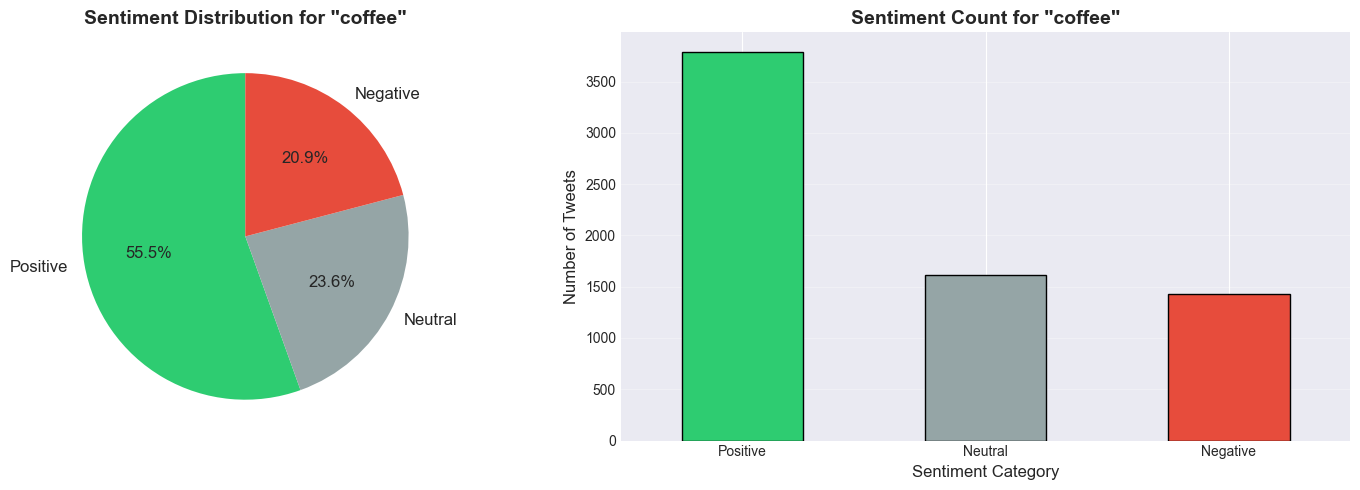

In [13]:
if len(df_brand) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pie chart
    sentiment_counts = df_brand['sentiment_category'].value_counts()
    colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'}
    pie_colors = [colors.get(cat, '#95a5a6') for cat in sentiment_counts.index]
    
    axes[0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
                startangle=90, colors=pie_colors, textprops={'fontsize': 12})
    axes[0].set_title(f'Sentiment Distribution for "{BRAND_KEYWORD}"', fontsize=14, fontweight='bold')
    
    # Bar chart
    sentiment_counts.plot(kind='bar', ax=axes[1], color=pie_colors, edgecolor='black')
    axes[1].set_title(f'Sentiment Count for "{BRAND_KEYWORD}"', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Sentiment Category', fontsize=12)
    axes[1].set_ylabel('Number of Tweets', fontsize=12)
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 9.2 Sentiment Score Distribution

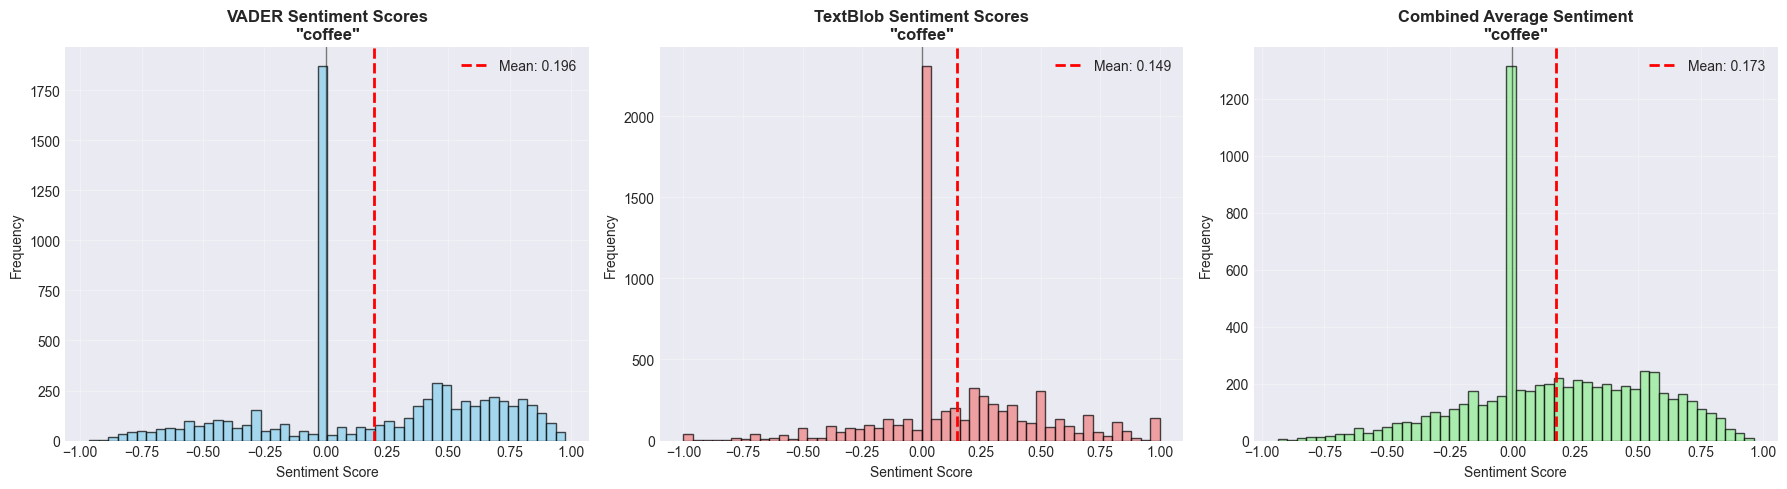

In [14]:
if len(df_brand) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # VADER scores
    axes[0].hist(df_brand['vader_score'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_title(f'VADER Sentiment Scores\n"{BRAND_KEYWORD}"', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Sentiment Score')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(df_brand['vader_score'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {df_brand["vader_score"].mean():.3f}')
    axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # TextBlob scores
    axes[1].hist(df_brand['textblob_score'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[1].set_title(f'TextBlob Sentiment Scores\n"{BRAND_KEYWORD}"', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Sentiment Score')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(df_brand['textblob_score'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {df_brand["textblob_score"].mean():.3f}')
    axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Average scores
    axes[2].hist(df_brand['avg_sentiment'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[2].set_title(f'Combined Average Sentiment\n"{BRAND_KEYWORD}"', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Sentiment Score')
    axes[2].set_ylabel('Frequency')
    axes[2].axvline(df_brand['avg_sentiment'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {df_brand["avg_sentiment"].mean():.3f}')
    axes[2].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 9.3 Top Hashtags Visualization

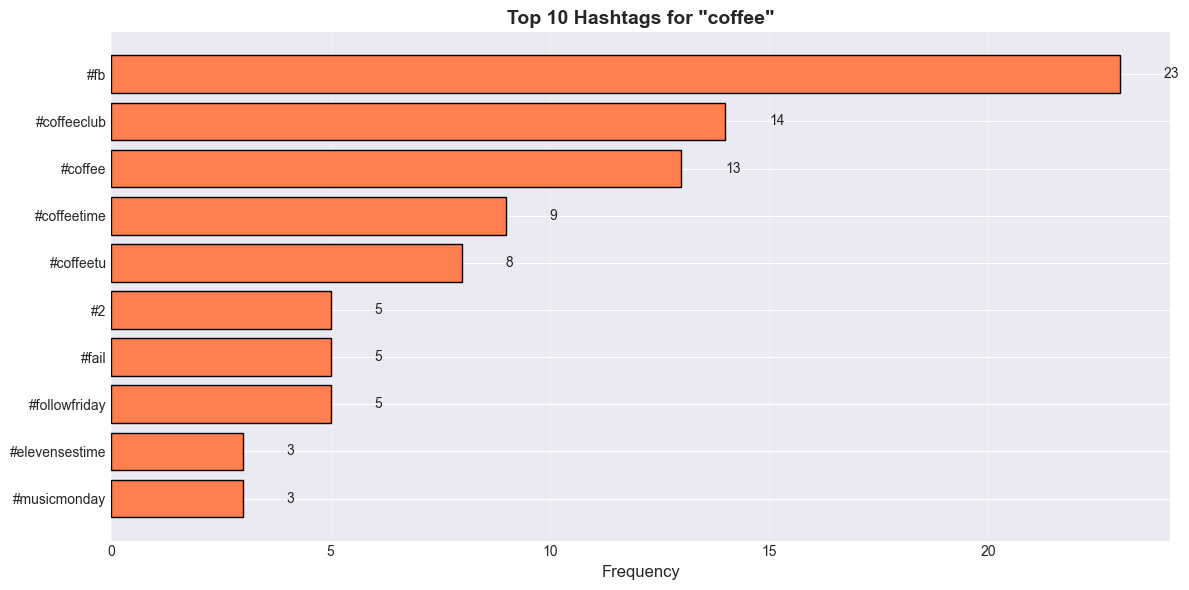

In [15]:
if len(df_brand) > 0 and len(hashtag_df) > 0:
    plt.figure(figsize=(12, 6))
    
    top_10_hashtags = hashtag_df.head(10)
    plt.barh(range(len(top_10_hashtags)), top_10_hashtags['Count'], color='coral', edgecolor='black')
    plt.yticks(range(len(top_10_hashtags)), ['#' + tag for tag in top_10_hashtags['Hashtag']])
    plt.xlabel('Frequency', fontsize=12)
    plt.title(f'Top 10 Hashtags for "{BRAND_KEYWORD}"', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(top_10_hashtags['Count']):
        plt.text(v + 1, i, str(v), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### 9.4 Word Cloud

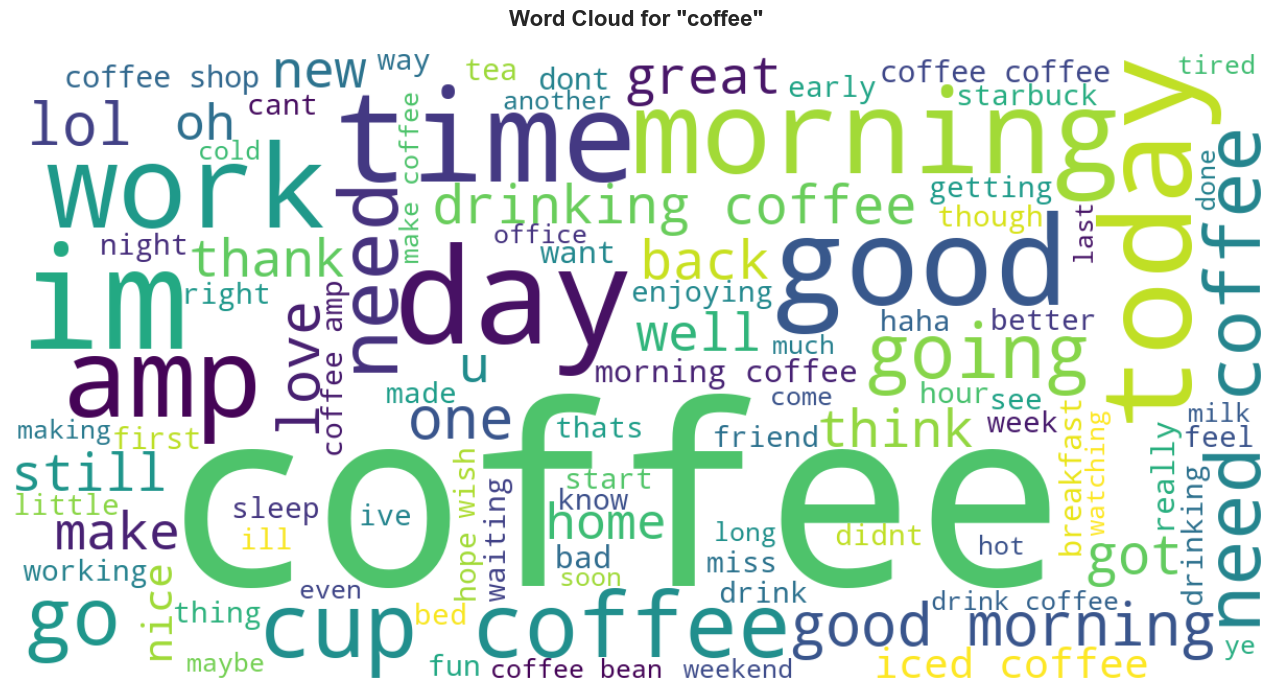

In [16]:
if len(df_brand) > 0:
    # Combine all cleaned text
    text_combined = ' '.join(df_brand['text_lemmatized'].dropna().astype(str))
    
    if len(text_combined) > 0:
        # Generate word cloud
        wordcloud = WordCloud(width=1200, height=600, 
                              background_color='white',
                              colormap='viridis',
                              max_words=100).generate(text_combined)
        
        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for "{BRAND_KEYWORD}"', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    else:
        print('Not enough text data to generate word cloud.')

### 9.5 Sentiment by Category Comparison

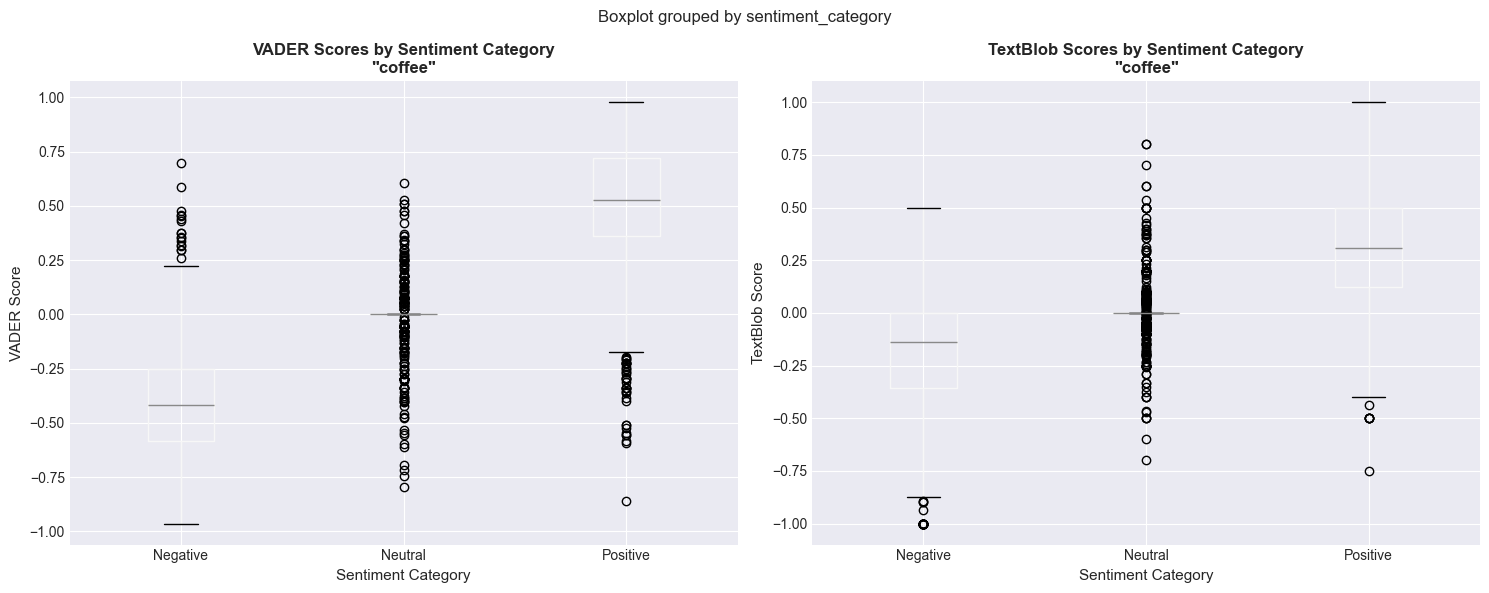

In [17]:
if len(df_brand) > 0:
    # Box plot for sentiment scores by category
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # VADER scores by category
    df_brand.boxplot(column='vader_score', by='sentiment_category', ax=axes[0])
    axes[0].set_title(f'VADER Scores by Sentiment Category\n"{BRAND_KEYWORD}"', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Sentiment Category', fontsize=11)
    axes[0].set_ylabel('VADER Score', fontsize=11)
    plt.sca(axes[0])
    plt.xticks(rotation=0)
    
    # TextBlob scores by category
    df_brand.boxplot(column='textblob_score', by='sentiment_category', ax=axes[1])
    axes[1].set_title(f'TextBlob Scores by Sentiment Category\n"{BRAND_KEYWORD}"', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Sentiment Category', fontsize=11)
    axes[1].set_ylabel('TextBlob Score', fontsize=11)
    plt.sca(axes[1])
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

## 10. Save Brand Analysis Results

In [18]:
if len(df_brand) > 0:
    # Create output directory
    import os
    output_dir = 'brand_analysis_results'
    os.makedirs(output_dir, exist_ok=True)
    
    # Sanitize brand name for filename
    safe_brand_name = BRAND_KEYWORD.lower().replace(' ', '_').replace('/', '_')
    
    # Save analyzed tweets
    output_file = f'{output_dir}/{safe_brand_name}_sentiment_analysis.csv'
    df_brand.to_csv(output_file, index=False)
    print(f'Brand sentiment analysis saved to: {output_file}')
    
    # Save hashtags
    if len(hashtag_df) > 0:
        hashtag_file = f'{output_dir}/{safe_brand_name}_hashtags.csv'
        hashtag_df.to_csv(hashtag_file, index=False)
        print(f'Hashtags saved to: {hashtag_file}')
    
    # Save keywords
    if len(keyword_df) > 0:
        keyword_file = f'{output_dir}/{safe_brand_name}_keywords.csv'
        keyword_df.to_csv(keyword_file, index=False)
        print(f'Keywords saved to: {keyword_file}')
    
    print(f'\nAll results saved in: {output_dir}/')

Brand sentiment analysis saved to: brand_analysis_results/coffee_sentiment_analysis.csv
Hashtags saved to: brand_analysis_results/coffee_hashtags.csv
Keywords saved to: brand_analysis_results/coffee_keywords.csv

All results saved in: brand_analysis_results/


## 11. Summary Report

In [19]:
if len(df_brand) > 0:
    print('\n' + '='*80)
    print(f'BRAND ANALYSIS SUMMARY: "{BRAND_KEYWORD.upper()}"')
    print('='*80)
    
    print(f'\nDATASET:')
    print(f'  • Total tweets analyzed: {len(df_brand):,}')
    print(f'  • Percentage of dataset: {len(df_brand)/len(df)*100:.2f}%')
    
    print(f'\nSENTIMENT BREAKDOWN:')
    sentiment_counts = df_brand['sentiment_category'].value_counts()
    for category in ['Positive', 'Neutral', 'Negative']:
        count = sentiment_counts.get(category, 0)
        pct = (count / len(df_brand) * 100) if len(df_brand) > 0 else 0
        print(f'  • {category:8s}: {count:6,} tweets ({pct:5.2f}%)')
    
    print(f'\nSENTIMENT SCORES:')
    print(f'  • VADER Score:    {df_brand["vader_score"].mean():+.4f}')
    print(f'  • TextBlob Score: {df_brand["textblob_score"].mean():+.4f}')
    print(f'  • Average Score:  {df_brand["avg_sentiment"].mean():+.4f}')
    
    if len(hashtag_df) > 0:
        print(f'\nTOP 5 HASHTAGS:')
        for idx, row in hashtag_df.head(5).iterrows():
            print(f'  {idx+1}. #{row["Hashtag"]:15s} - {row["Count"]:,} times')
    
    if len(keyword_df) > 0:
        print(f'\nTOP 5 KEYWORDS:')
        for i, (idx, row) in enumerate(keyword_df.head(5).iterrows(), 1):
            print(f'  {i}. {row["Keyword"]:15s} - Score: {row["TF-IDF Score"]:.4f}')
    
    # Overall sentiment
    avg_sentiment = df_brand['avg_sentiment'].mean()
    if avg_sentiment > 0.05:
        overall = 'POSITIVE - Brand perception is favorable!'
    elif avg_sentiment < -0.05:
        overall = 'NEGATIVE - Brand may need reputation management.'
    else:
        overall = 'NEUTRAL - Mixed or moderate brand sentiment.'
    
    print(f'\nOVERALL BRAND SENTIMENT:')
    print(f'  {overall}')
    
    print('\n' + '='*80)
    print('Analysis Complete!')
    print('='*80)
else:
    print('\nNo analysis to report. Please try a different keyword.')


BRAND ANALYSIS SUMMARY: "COFFEE"

DATASET:
  • Total tweets analyzed: 6,834
  • Percentage of dataset: 0.46%

SENTIMENT BREAKDOWN:
  • Positive:  3,792 tweets (55.49%)
  • Neutral :  1,613 tweets (23.60%)
  • Negative:  1,429 tweets (20.91%)

SENTIMENT SCORES:
  • VADER Score:    +0.1958
  • TextBlob Score: +0.1493
  • Average Score:  +0.1726

TOP 5 HASHTAGS:
  1. #fb              - 23 times
  2. #coffeeclub      - 14 times
  3. #coffee          - 13 times
  4. #coffeetime      - 9 times
  5. #coffeetu        - 8 times

TOP 5 KEYWORDS:
  1. coffee          - Score: 1611.3578
  2. morning         - Score: 380.4923
  3. good            - Score: 319.7184
  4. im              - Score: 314.8624
  5. day             - Score: 274.3486

OVERALL BRAND SENTIMENT:
  POSITIVE - Brand perception is favorable!

Analysis Complete!


## 12. Multi-Brand Comparison Analysis

Keyword: "apple"
Found 3,630 tweets (0.25% of dataset)
Keyword: "google"
Found 2,618 tweets (0.18% of dataset)
Keyword: "google"
Found 2,618 tweets (0.18% of dataset)
Keyword: "microsoft"
Found 523 tweets (0.04% of dataset)
Keyword: "microsoft"
Found 523 tweets (0.04% of dataset)
Keyword: "amazon"
Found 579 tweets (0.04% of dataset)
Keyword: "amazon"
Found 579 tweets (0.04% of dataset)

BRAND COMPARISON ANALYSIS
    Brand  Total Tweets  Positive  Neutral  Negative  Avg Sentiment  VADER Score  TextBlob Score
    Apple          3630      1753      868      1009       0.105414     0.120889        0.089939
   Google          2618      1328      672       618       0.124613     0.139958        0.109267
Microsoft           523       260      104       159       0.085158     0.100249        0.070067
   Amazon           579       421       52       106       0.204961     0.281529        0.128393

BRAND COMPARISON ANALYSIS
    Brand  Total Tweets  Positive  Neutral  Negative  Avg Sentiment  VAD

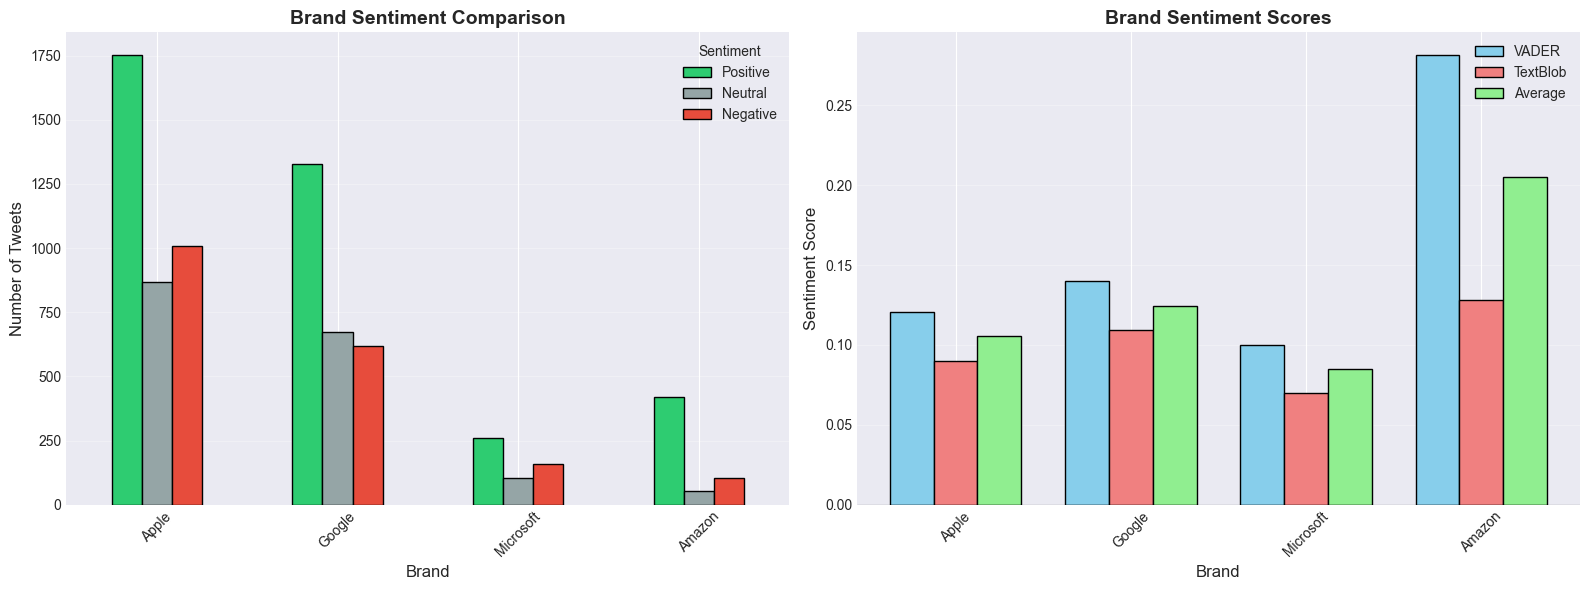


Brand comparison saved to: brand_analysis_results/brand_comparison.csv


In [20]:
brands_to_compare = ['apple', 'google', 'microsoft', 'amazon']

comparison_results = []

for brand in brands_to_compare:
    df_temp = filter_tweets_by_keyword(df, brand)
    
    if len(df_temp) > 0:
        df_temp['vader_score'] = df_temp['text_original'].apply(get_vader_sentiment)
        df_temp['textblob_score'] = df_temp['text_original'].apply(get_textblob_sentiment)
        df_temp['avg_sentiment'] = (df_temp['vader_score'] + df_temp['textblob_score']) / 2
        df_temp['sentiment_category'] = df_temp['avg_sentiment'].apply(classify_sentiment)
        
        sentiment_counts = df_temp['sentiment_category'].value_counts()
        
        comparison_results.append({
            'Brand': brand.capitalize(),
            'Total Tweets': len(df_temp),
            'Positive': sentiment_counts.get('Positive', 0),
            'Neutral': sentiment_counts.get('Neutral', 0),
            'Negative': sentiment_counts.get('Negative', 0),
            'Avg Sentiment': df_temp['avg_sentiment'].mean(),
            'VADER Score': df_temp['vader_score'].mean(),
            'TextBlob Score': df_temp['textblob_score'].mean()
        })

if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    
    print('\nBRAND COMPARISON ANALYSIS')
    print('='*100)
    print(comparison_df.to_string(index=False))
    print('='*100)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sentiment_data = comparison_df[['Brand', 'Positive', 'Neutral', 'Negative']].set_index('Brand')
    sentiment_data.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#95a5a6', '#e74c3c'], edgecolor='black')
    axes[0].set_title('Brand Sentiment Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Brand', fontsize=12)
    axes[0].set_ylabel('Number of Tweets', fontsize=12)
    axes[0].legend(title='Sentiment')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    x = range(len(comparison_df))
    width = 0.25
    axes[1].bar([i - width for i in x], comparison_df['VADER Score'], width, label='VADER', color='skyblue', edgecolor='black')
    axes[1].bar(x, comparison_df['TextBlob Score'], width, label='TextBlob', color='lightcoral', edgecolor='black')
    axes[1].bar([i + width for i in x], comparison_df['Avg Sentiment'], width, label='Average', color='lightgreen', edgecolor='black')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comparison_df['Brand'], rotation=45)
    axes[1].set_title('Brand Sentiment Scores', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Brand', fontsize=12)
    axes[1].set_ylabel('Sentiment Score', fontsize=12)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    comparison_df.to_csv('brand_analysis_results/brand_comparison.csv', index=False)
    print('\nBrand comparison saved to: brand_analysis_results/brand_comparison.csv')
else:
    print('\nNo brands found for comparison.')